In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from AuctionSimulator.Agents.Sellers import AuctionedObject, Auctioneer
from AuctionSimulator.Agents.Bidders import SimpleBidder
from AuctionSimulator.AuctionHouse import Throttling as Thr
from AuctionSimulator.AuctionHouse import AuctionHouse

n_rounds = 1000
n_objects = 100
n_bidders = 130

budgets = np.array([30., 50., 80., 100., 120., 200., 300., 500., 1000.])
budgets_p = np.ones(9) / 9
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(n_bidders)])

fees = np.array([0, 0.3, 0.36, 0.68])
fees_p = np.array([0.36, 0.14, 0.30, 0.2])
fees_init = np.array([np.random.choice(fees, p=fees_p) for i in range(n_objects)])

auctioned_objects = np.array([AuctionedObject(i, 3, np.inf, fee=fees_init[i]) for i in range(n_objects)])
auctioneer = Auctioneer(auctioned_objects, x0=np.ones(n_objects) * 0)
bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(n_bidders)])

# throttling
# plan = Thr.Planning(n_rounds, budgets_init).sigmoid_planning(s=0.2, t0=13)
# plan = Thr.Planning(n_rounds, budgets_init).uniform_planning()
plan = Thr.Planning(n_rounds, budgets_init).empirical_planning()
probability_function = Thr.Probability().linear_probability
probability_function_kwargs = {'floor': 0.25}
# probability_function = Thr.Probability().total_probability
# probability_function_kwargs = {'prob_under_plan': 0.5}
decision_function = Thr.Decision.binomial_decision

house = AuctionHouse.Controller(n_rounds, auctioneer, bidders,
                                throttling=True, 
                                plan=plan, probability_function=probability_function,
                                probability_function_kwargs=probability_function_kwargs
                                )

In [23]:
%%time
house.run()

Wall time: 768 ms


In [24]:
bid_df = house.bidder_tracker.make_dataframe()
auc_df = house.auction_tracker.make_dataframe()
from itertools import product
auc_df.columns = pd.Index(product(['auction'], auc_df.columns))
df = bid_df.join(auc_df)

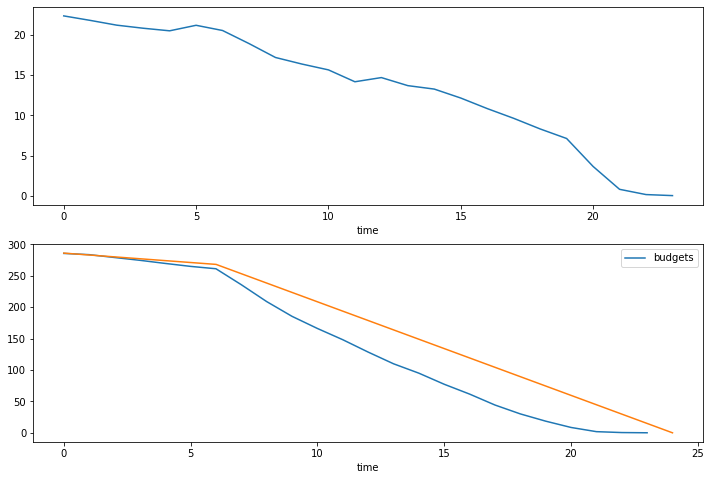

In [25]:
plt.rc('figure', figsize=(12, 8))
fig, (ax1, ax2) = plt.subplots(2, 1)

time = auc_df['auction']['time'].dt.hour

df = bid_df['bids'].groupby(time).mean()
df.mean(axis=1).plot(ax=ax1)

df = bid_df['budgets'].groupby(time).max()
df.mean(axis=1).plot(ax=ax2, label='budgets')
ax2.plot(house.time, plan.mean(axis=1))
ax2.legend()

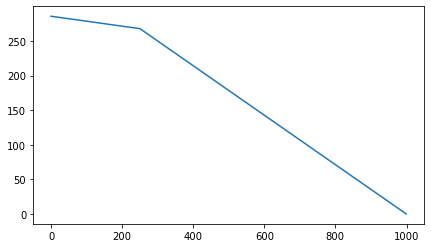

In [12]:
plt.plot(plan.mean(axis=1))

In [5]:
auc_df = house.auction_tracker.make_dataframe()
d = auc_df.groupby(auc_df.time.dt.hour).count()['object_id']

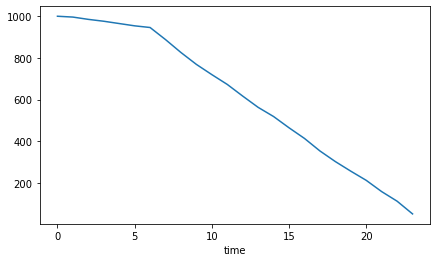

In [6]:
plt.rc('figure', figsize=(7,4))
d[::-1].cumsum()[::-1].plot()